In [1]:
# Python version
from platform import python_version
print('Python version used in this notebook:', python_version())

Python version used in this notebook: 3.8.8


In [2]:
# Imports
import os
import random
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

In [3]:
os.chdir(r'E:\OneDrive\Documentos\Cursos\Estudos\Netflix')

In [4]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

path = os.path.realpath(r'kaggle/input/netflix-prize-data')

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

E:\OneDrive\Documentos\Cursos\Estudos\Netflix\kaggle\input\netflix-prize-data\combined_data_1.txt
E:\OneDrive\Documentos\Cursos\Estudos\Netflix\kaggle\input\netflix-prize-data\combined_data_2.txt
E:\OneDrive\Documentos\Cursos\Estudos\Netflix\kaggle\input\netflix-prize-data\combined_data_3.txt
E:\OneDrive\Documentos\Cursos\Estudos\Netflix\kaggle\input\netflix-prize-data\combined_data_4.txt
E:\OneDrive\Documentos\Cursos\Estudos\Netflix\kaggle\input\netflix-prize-data\movie_titles.csv


In [5]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

path = os.path.realpath(r'kaggle/working')

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

E:\OneDrive\Documentos\Cursos\Estudos\Netflix\kaggle\working\fullcombined_data.csv
E:\OneDrive\Documentos\Cursos\Estudos\Netflix\kaggle\working\movie_sparse_matrix.npz
E:\OneDrive\Documentos\Cursos\Estudos\Netflix\kaggle\working\sparse_matrix_user_trunc.npz
E:\OneDrive\Documentos\Cursos\Estudos\Netflix\kaggle\working\test_data.csv
E:\OneDrive\Documentos\Cursos\Estudos\Netflix\kaggle\working\train_data.csv


In [6]:
# Plots parameters
matplotlib.use('nbagg')
plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style('whitegrid')

## Loading Data

To load the data, we will perform the following operations:

- 1- Read the rows of all available files.
- 2- Combine all rows from all files into a single file.
- 3- Load the generated file into a pandas dataframe.

In [7]:
# From TXT files, we are going to create a full combined data
# If the file does not exist, we create the file in write mode (w)
if not os.path.isfile(r'kaggle/working/fullcombined_data.csv'):    
    # Process start time
    start = datetime.now()

    # Path and files that is going to be combined to a full file
    files = [r'kaggle/input/netflix-prize-data/combined_data_1.txt',
                r'kaggle/input/netflix-prize-data/combined_data_2.txt', 
                r'kaggle/input/netflix-prize-data/combined_data_3.txt', 
                r'kaggle/input/netflix-prize-data/combined_data_4.txt']

    filecount = 0
    for file in files:
        if os.path.isfile(file):
            filecount += 1

    # If there is any combined_data*.txt file in path
    if filecount > 0:
        # Open and create file for recording
        dataset = open('kaggle/working/fullcombined_data.csv', mode = 'w')    
        # Create list for files rows
        rows = list()    
        
        # Loop for each TXT file
        for file in files:        
            # Print a message
            print("Reading the file {}...".format(file))        
            # With the file open, we extract the rows
            with open(file) as f:
                # Loop through each row
                for row in f:
                    # Deleting list content
                    del rows[:]                 
                    # Divide the row of the file by the end of line character
                    row = row.strip()                
                    # If we find "colon" at the end of the row, we do replace by removing the character, as we just want the movie id
                    if row.endswith(':'):
                        movie_id = row.replace(':', '')                    
                    # If not, we create a comprehension list to separate the columns by comma
                    else:                    
                        # Split the columns
                        rows = [x for x in row.split(',')]                    
                        # Use movie id at index zero position
                        rows.insert(0, movie_id)                    
                        # Write the result to the new file
                        dataset.write(','.join(rows))
                        dataset.write('\n')                    
            print("Finished.\n")        
        dataset.close()

        # Print elapsed time
        print('Elapsed time to load all the files:', datetime.now() - start)

In [8]:
# Creating the pandas dataframe from the combined file
print("Creating the pandas dataframe from the combined file...")
df_netflix = pd.read_csv(r'kaggle/working/fullcombined_data.csv', sep = ',', names = ['movie', 'user', 'rating', 'date'])
df_netflix.date = pd.to_datetime(df_netflix.date)
print('Finished.')

Creating the pandas dataframe from the combined file...
Finished.


In [9]:
# Sorting the dataframe by date
print('Sorting the dataframe by date..')
df_netflix.sort_values(by = 'date', inplace = True)
print('Finished.')

Sorting the dataframe by date..
Finished.


In [10]:
# Shape
df_netflix.shape

(100480507, 4)

In [11]:
# Viewing the data
df_netflix.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


# Exploratory Data Analysis

In [12]:
# Data summary
print("Data summary")
print("-"*50)
print("Movie total count:", len(np.unique(df_netflix.movie)))
print("Users total count:", len(np.unique(df_netflix.user)))
print("Rating total count:", df_netflix.shape[0])

Data summary
--------------------------------------------------
Movie total count: 17770
Users total count: 480189
Rating total count: 100480507


In [13]:
# Let's save this two variables to use later
total_users = len(np.unique(df_netflix.user))
total_movies = len(np.unique(df_netflix.movie))

In [14]:
# Describe rating column from the dataframe
df_netflix.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [15]:
# Check if we have any null value
sum(df_netflix.isnull().any())

0

In [16]:
# Check if we have any duplicaded data (for this case we wil not consider date column)
sum(df_netflix.duplicated(['movie', 'user', 'rating']))

0

### Let's split the data into training and testing before proceeding with an exploratory analysis, as some analyzes only make sense for training data. We will use the 80/20 ratio for training / testing.

In [17]:
# We will create a dataset on disk with the training data
# That way we don't need to run the entire charging process again every time we run this process
if not os.path.isfile(r'kaggle/working/train_data.csv'):
    df_netflix.iloc[:int(df_netflix.shape[0] * 0.80)].to_csv(r"kaggle/working/train_data.csv", index = False)

In [18]:
# We will create a dataset on disk with the test data
# That way we don't need to run the entire charging process again every time we run this process
if not os.path.isfile(r'kaggle/working/test_data.csv'):
    df_netflix.iloc[int(df_netflix.shape[0] * 0.80):].to_csv(r"kaggle/working/test_data.csv", index = False)

In [19]:
# We delete the main dataframe to free the memory
del df_netflix

In [20]:
# Load the files into pandas dataframe
df_netflix_train = pd.read_csv(r"kaggle/working/train_data.csv", parse_dates = ['date'])
df_netflix_test = pd.read_csv(r"kaggle/working/test_data.csv")

In [21]:
# Train data summary
print("Train data summary")
print("-"*50)
print("Movies total count:", len(np.unique(df_netflix_train.movie)))
print("Users total count:", len(np.unique(df_netflix_train.user)))
print("Rating total count:", df_netflix_train.shape[0])

Train data summary
--------------------------------------------------
Movies total count: 17424
Users total count: 405041
Rating total count: 80384405


In [22]:
# Test data summary
print("Test data summary")
print("-"*50)
print("Movies total count:", len(np.unique(df_netflix_test.movie)))
print("Users total count:", len(np.unique(df_netflix_test.user)))
print("Rating total count:", df_netflix_test.shape[0])

Test data summary
--------------------------------------------------
Movies total count: 17757
Users total count: 349312
Rating total count: 20096102


### The function below will adjust the measurements in thousands, millions and billions to make the graphs easier to read.

In [23]:
# Function for adjusting measurement display units
def display_units(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

In [24]:
# Supress warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Let's look at the distribution of ratings.

<IPython.core.display.Javascript object>


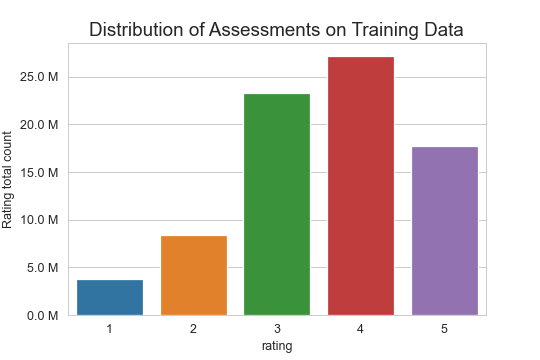

In [25]:
# Plot
fig, ax = plt.subplots()
plt.title('Distribution of Assessments on Training Data', fontsize = 15)
sns.countplot(df_netflix_train.rating)
ax.set_yticklabels([display_units(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('Rating total count')
plt.show()

### Does the day of the week have an influence on the user's evaluation? Let's include a column with the day of the week and find out.

In [26]:
# Parameter to avoid warning due to high data volume
pd.options.mode.chained_assignment = None  

In [27]:
start = datetime.now()

# Extract the day of the week and write to a new column
df_netflix_train['weekday'] = df_netflix_train['date'].dt.strftime("%A")

# Print elapsed time
print('Elapsed time:', datetime.now() - start)

Elapsed time: 0:07:08.215719


In [28]:
# print dataframe with new column
df_netflix_train.head()

,movie,user,rating,date,weekday
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


<IPython.core.display.Javascript object>


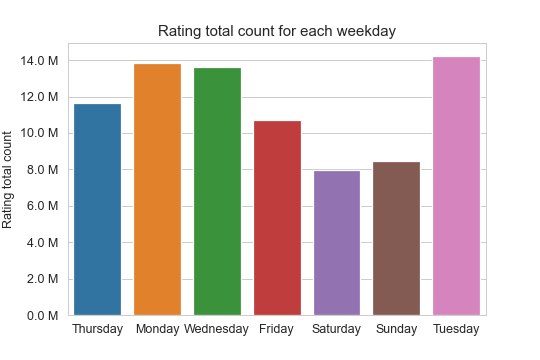

In [29]:
# Plot
fig, ax = plt.subplots()
sns.countplot(x = 'weekday', data = df_netflix_train, ax = ax)
plt.title('Rating total count for each weekday')
plt.ylabel('Rating total count')
plt.xlabel('')
ax.set_yticklabels([display_units(item, 'M') for item in ax.get_yticks()])
plt.show()

### It's curious why Tuesday has more ratings, I mean, why this day? So because of that, let's calculate the average of ratings per day of the week.

In [30]:
# Average of ratings per day of the week
average_weekday = df_netflix_train.groupby(by = ['weekday'])['rating'].mean()
print("Average Ratings")
print("-"*30)
print(average_weekday)

Average Ratings
------------------------------
weekday
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64


### The day of the week does not seem to have an influence on the users' evaluation.

### Now let's look at user ratings over time.

<IPython.core.display.Javascript object>


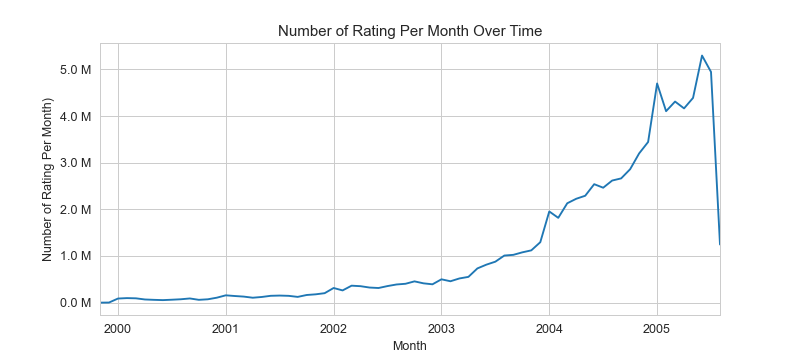

In [31]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
ax = df_netflix_train.resample('m', on = 'date')['rating'].count().plot()
ax.set_title('Number of Rating Per Month Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Rating Per Month)')
ax.set_yticklabels([display_units(item, 'M') for item in ax.get_yticks()])
plt.show()

### Clearly there is an increase in user ratings over time, either due to more users or because users have learned how to use the feature.

### Now let's check out what are the users who rated the most.

In [32]:
# Number of ratings per user
num_aval_por_user = df_netflix_train.groupby(by = 'user')['rating'].count().sort_values(ascending = False)
num_aval_por_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

In [33]:
# Summary
num_aval_por_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

<IPython.core.display.Javascript object>


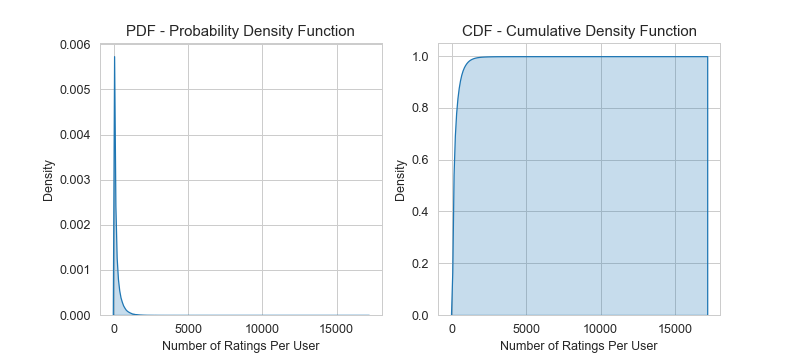

In [34]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
ax1 = plt.subplot(121)
sns.kdeplot(num_aval_por_user, shade = True, ax = ax1)
plt.xlabel('Number of Ratings Per User')
plt.title("PDF - Probability Density Function")
ax2 = plt.subplot(122)
sns.kdeplot(num_aval_por_user, shade = True, cumulative = True, ax = ax2)
plt.xlabel('Number of Ratings Per User')
plt.title('CDF - Cumulative Density Function')
plt.show()

### We can note that the vast majority of users have less than 1000 ratings.

### Now how many ratings are in the last 5% of all ratings??

In [35]:
# Let's extract the percentiles
percentiles = num_aval_por_user.quantile(np.arange(0,1.01,0.01), interpolation = 'higher')
percentiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

<IPython.core.display.Javascript object>


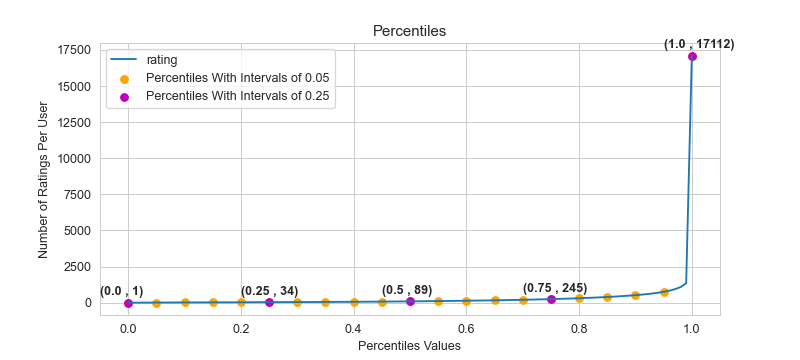

In [36]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
plt.title("Percentiles")
percentiles.plot()

# Quartiles with a difference of 0.05
plt.scatter(x = percentiles.index[::5], 
            y = percentiles.values[::5], 
            c = 'orange', 
            label = "Percentiles With Intervals of 0.05")

# Quartiles with a difference of 0.25
plt.scatter(x = percentiles.index[::25], 
            y = percentiles.values[::25], 
            c = 'm', 
            label = "Percentiles With Intervals of 0.25")

# Labels and caption
plt.ylabel('Number of Ratings Per User')
plt.xlabel('Percentiles Values')
plt.legend(loc = 'best')

# Let's mark the 25th, 50th, 75th and 100th percentiles
for x,y in zip(percentiles.index[::25], percentiles[::25]):
    plt.annotate(s = "({} , {})".format(x,y), xy = (x,y), xytext = (x-0.05, y+500), fontweight = 'bold')

plt.show()

### - There are some movies (which are very popular) that are rated by a large number of users.
    
### - But most movies (like 90%) have a few hundred ratings.

# Sparse Matrix

### Train Sparse Matrix

In [37]:
# We create the sparse matrix in Numpy format if it does not exist
# If it exists, we just load it from disk
if os.path.isfile(r'kaggle/working/train_sparse_matrix.npz'):
    train_sparse_matrix = sparse.load_npz(r'kaggle/working/train_sparse_matrix.npz')
    print("Sparse Matrix loaded.")
else: 
    train_sparse_matrix = sparse.csr_matrix((df_netflix_train.rating.values, (df_netflix_train.user.values, df_netflix_train.movie.values)),)
    print('Sparse Matrix created. Shape is: (user, movie): ', train_sparse_matrix.shape)
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Sparse Matrix saved on disk.')

Sparse Matrix created. Shape is: (user, movie):  (2649430, 17771)
Sparse Matrix saved on disk.


In [38]:
# We calculate the sparsity of the matrix
rows, columns = train_sparse_matrix.shape
elements_not_zero = train_sparse_matrix.count_nonzero()
print("Training Matrix Sparsity: {} % ".format(  (1 - (elements_not_zero / (rows * columns))) * 100) )

Training Matrix Sparsity: 99.8292709259195 % 


### Test Sparse Matrix

In [39]:
# We create the sparse matrix in Numpy format if it does not exist
# If it exists, we just load it from disk
if os.path.isfile('kaggle/working/test_sparse_matrix.npz'):
    test_sparse_matrix = sparse.load_npz('kaggle/working/test_sparse_matrix.npz')
    print("Sparse Matrix loaded.")
else: 
    test_sparse_matrix = sparse.csr_matrix((df_netflix_test.rating.values, (df_netflix_test.user.values, 
                                                                                 df_netflix_test.movie.values)),)
    print('Sparse Matrix created. Shape is: (user, movie): ', test_sparse_matrix.shape)
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Sparse Matrix saved on disk.')

Sparse Matrix created. Shape is: (user, movie):  (2649430, 17771)
Sparse Matrix saved on disk.


In [40]:
# We calculate the sparsity of the matrix
rows, columns = test_sparse_matrix.shape
elements_not_zero = test_sparse_matrix.count_nonzero()
print("Training Matrix Sparsity: {} % ".format(  (1 - (elements_not_zero / (rows * columns))) * 100) )

Training Matrix Sparsity: 99.95731772988694 % 


### We will calculate the global average of all movie ratings, average user rating and average movie rating.

In [41]:
# Below we calculate the global average of all user ratings.
train_average = dict()
train_average_global = train_sparse_matrix.sum() / train_sparse_matrix.count_nonzero()
train_average['global'] = train_average_global
train_average

{'global': 3.582890686321557}

### Let's build a function for calculating the average of ratings.

In [42]:
# Average funcion
def calculate_average_ratings(sparse_matrix, of_users):
    
    # Average user/axis ratings
    # 1 = user axis
    # 0 = movie axis
    ax = 1 if of_users else 0

    # Sum
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    
    # Boolean ratings matrix (whether a user rated a movie or not)
    is_rated = sparse_matrix!=0
    
    # Number of ratings for each user or movie
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # Maximum user ids and movies in sparse matrix
    u, m = sparse_matrix.shape
    
    # We created a dictionary of users and their average ratings
    rating_average = {i:sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i]!=0}

    # Returns the dictionary of rating averages
    return rating_average

### Below we calculate the average ratings per user.

In [43]:
# Users ratings average
train_average['user'] = calculate_average_ratings(train_sparse_matrix, of_users = True)
# Print the dict
train_average

{'global': 3.582890686321557,
 'user': {6: 3.5160550458715596,
  7: 3.992957746478873,
  10: 3.3781094527363185,
  25: 3.5,
  33: 3.787878787878788,
  42: 3.9322033898305087,
  59: 3.698717948717949,
  79: 3.5559947299077734,
  83: 4.0,
  87: 3.544642857142857,
  94: 2.8125,
  97: 3.182377049180328,
  131: 4.0,
  134: 4.703081232492997,
  142: 3.45,
  149: 4.25,
  158: 3.625,
  168: 4.208333333333333,
  169: 3.738562091503268,
  178: 3.0,
  183: 3.7096774193548385,
  188: 3.4456066945606696,
  189: 3.0,
  192: 3.522222222222222,
  195: 3.689655172413793,
  199: 3.974747474747475,
  201: 3.605714285714286,
  242: 2.8392857142857144,
  247: 4.019230769230769,
  248: 3.6511627906976742,
  261: 2.769230769230769,
  265: 3.680297397769517,
  266: 4.102222222222222,
  267: 3.325,
  268: 4.008,
  283: 3.4794816414686824,
  291: 3.4745762711864407,
  296: 3.789473684210526,
  298: 3.8052805280528053,
  299: 3.5555555555555554,
  301: 4.05524861878453,
  302: 3.212,
  304: 3.8051948051948052,
 

In [44]:
# Print
print('User Rating Average:', train_average['user'][149])

User Rating Average: 4.25


### Below we calculate the average ratings per movie.

In [45]:
# Average ratings per movie
train_average['movie'] =  calculate_average_ratings(train_sparse_matrix, of_users = False)
print('Movie Rating Average 32:', train_average['movie'][32])

Movie Rating Average 32: 3.9922680412371134


### Average PDFs and CDs. User ratings and movies (training data).

<IPython.core.display.Javascript object>


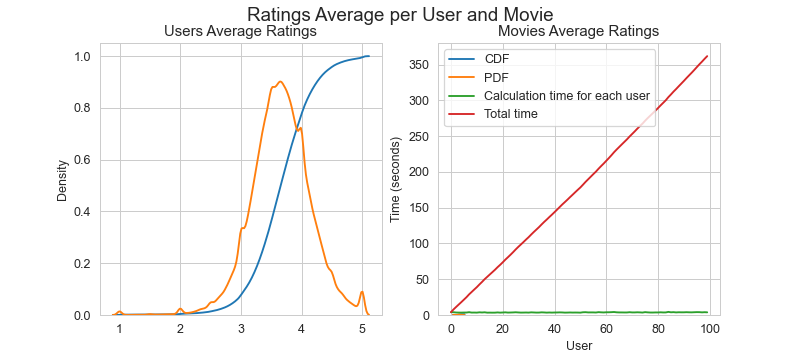

In [46]:
# Plot
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = plt.figaspect(.45))
fig.suptitle('Ratings Average per User and Movie', fontsize = 15)

ax1.set_title('Users Average Ratings')

# Obtemos a lista de avaliações médias do usuário no dicionário de médias.
users_average = [rat for rat in train_average['user'].values()]
sns.distplot(users_average, ax = ax1, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(users_average, ax = ax1, hist = False, label = 'PDF')

ax2.set_title('Movies Average Ratings')

# Obtemos a lista de avaliações médias de filmes do dicionário.
movies_average = [rat for rat in train_average['movie'].values()]
sns.distplot(movies_average, ax = ax2, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(movies_average, ax = ax2, hist = False, label = 'PDF')

plt.show()

### Cold Start Problem

In [47]:
# Users Cold start
train_users = len(train_average['user'])
new_users = total_users - train_users

# Print
print('Users total count:', total_users)
print('Total training users count:', train_users)
print('Total users not count in training: {} ({}%)'.format(new_users, np.round((new_users / total_users) * 100, 2)))

Users total count: 480189
Total training users count: 405041
Total users count not in training: 75148 (15.65%)


### 75148 users are not part of the training data, that is, we cannot learn the evaluation pattern of these users! This is the problem with cold start.

In [48]:
# Cold start de filmes
train_movies = len(train_average['movie'])
new_movies = total_movies - train_movies

# Print
print('Movies total count:', total_movies)
print('Total training movies count:', train_movies)
print('Total movies not count in training: {} ({}%)'.format(new_movies, np.round((new_movies/total_movies)*100, 2)))

Movies total count: 17770
Total training movies count: 17424
Total movies count not in training: 346 (1.95%)


### 346 movies do not appear in training data. We will have to deal with this when we work especially on the Machine Learning model.

# User Similarity Matrix

In [49]:
# Função de cálculo de similaridade
def calculate_user_similarity(sparse_matrix, 
                                 compute_for_few = False, 
                                 top = 100, 
                                 verbose = False, 
                                 verb_for_n_rows = 20,
                                 draw_time_taken = True):
    
    # Control variables
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) 
    time_taken = list()
    rows, cols, data = list(), list(), list()
    if verbose: print("Calculating top", top, "similarities for each user...")
    start = datetime.now()
    temp = 0
    
    # Loop through matrix
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp + 1
        prev = datetime.now()
        
        # Calculating cosine similarity
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("Calculation completed for {} users [  elapsed time : {}  ]".format(temp, datetime.now()-start))
            
    if verbose: print('Sparse matrix creation from computed similarities...')    
        
    if draw_time_taken:
        plt.plot(time_taken, label = 'Calculation time for each user')
        plt.plot(np.cumsum(time_taken), label = 'Total time')
        plt.legend(loc = 'best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape = (no_of_users, no_of_users)), time_taken

In [50]:
# We calculate the similarity

# Start time
start = datetime.now()

# Calculate the similarity
user_sparse_matrix, _ = calculate_user_similarity(train_sparse_matrix, 
                                                      compute_for_few = True, 
                                                      top = 100, 
                                                      verbose = True)

print("Total Processing Time:", datetime.now() - start)

Calculating top 100 similarities for each user...
Calculation completed for 20 users [  elapsed time : 0:01:10.110763  ]
Calculation completed for 40 users [  elapsed time : 0:02:20.198548  ]
Calculation completed for 60 users [  elapsed time : 0:03:31.614601  ]
Calculation completed for 80 users [  elapsed time : 0:04:45.573087  ]
Calculation completed for 100 users [  elapsed time : 0:06:01.687596  ]
Sparse matrix creation from computed similarities...
Total Processing Time: 0:06:10.001644


### We have **405.041 users** in our training set and computing the similarities between them (**dimensional vector of 17K**) is time consuming.


### We will try to reduce the dimensions using SVD in order to speed up the process.

# Dimensionality Reduction with TruncatedSVD

In [51]:
# Dimensionality reduction

# Start time
start = datetime.now()

# Creates the TruncatedSVD object by reducing dimensionality to 500 dimensions
netflix_svd = TruncatedSVD(n_components = 500, algorithm = 'randomized', random_state = 15)

# Apply TruncatedSVD
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)

print("Total Processing Time:", datetime.now() - start)

Total Processing Time: 0:19:28.475010


### Let's calculate the variance explained by the components.

<IPython.core.display.Javascript object>


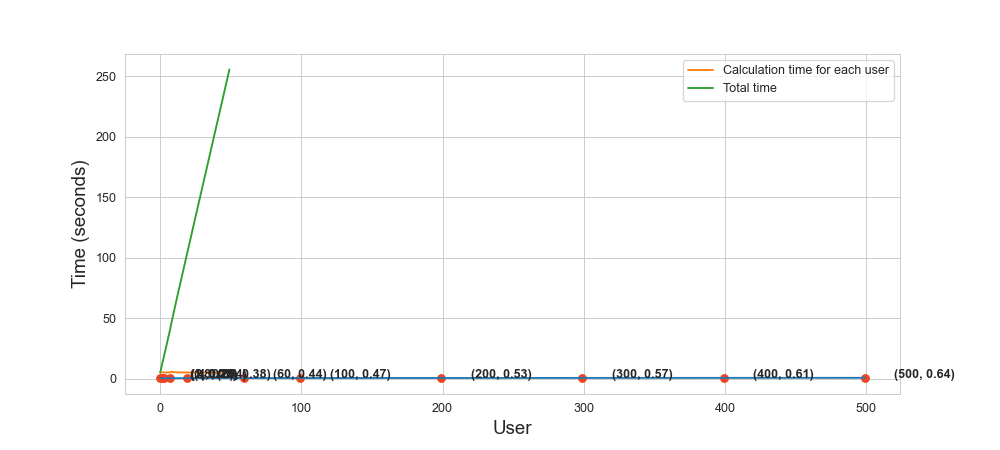

In [52]:
# Calculates explained variance
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

# Plot
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = plt.figaspect(.45))

ax1.set_ylabel("Variance explained", fontsize = 15)
ax1.set_xlabel("Latent Factors", fontsize = 15)
ax1.plot(expl_var)

# Let's mark some combinations of (latent factors, explained variance) to make the graph clearer
ind = [1, 2, 4, 8, 20, 60, 100, 200, 300, 400, 500]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c = '#ee4422')

for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy = (i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight = 'bold')

plt.show()

### With 500 components we explain approximately 65% ​​of the data variance. That's enough for our example.

In [53]:
# Let's design our matrix in 500 dimensional space
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)
print("Total Processing Time:", datetime.now() - start)

Total Processing Time: 0:00:27.137325


In [54]:
# Shape
trunc_matrix.shape

(2649430, 500)

In [55]:
# Let's create and save to disk the array with its dimensionality reduced to 500 dimensions
if not os.path.isfile('kaggle/working/sparse_matrix_user_trunc.npz'):
    sparse_matrix_user_trunc = sparse.csr_matrix(trunc_matrix)
    sparse.save_npz('kaggle/working/sparse_matrix_user_trunc', sparse_matrix_user_trunc)
else:
    sparse_matrix_user_trunc = sparse.load_npz('kaggle/working/sparse_matrix_user_trunc.npz')

In [56]:
# Shape
sparse_matrix_user_trunc.shape

(2649430, 500)

In [57]:
# Calculate user similarity

# Start time
start = datetime.now()

# Calculate the similarity
trunc_sim_matrix, _ = calculate_user_similarity(sparse_matrix_user_trunc, 
                                                   compute_for_few = True, 
                                                   top = 50, 
                                                   verbose = True) 

print("Total Processing Time:", datetime.now() - start)

Calculating top 50 similarities for each user...
Calculation completed for 20 users [  elapsed time : 0:01:43.191169  ]
Calculation completed for 40 users [  elapsed time : 0:03:24.808830  ]
Sparse matrix creation from computed similarities...
Total Processing Time: 0:04:38.406769


# Movie Similarity Matrix

In [58]:
# Calculate movie similarity

# Start time
start = datetime.now()

# Create if doest not exist on disk
if not os.path.isfile('kaggle/working/movie_sparse_matrix.npz'):
    movie_sparse_matrix = cosine_similarity(X = train_sparse_matrix.T, dense_output = False)
    print("Matriz created.")
    sparse.save_npz("kaggle/working/movie_sparse_matrix.npz", movie_sparse_matrix)
    print("Matriz saved on disk.")
else:
    movie_sparse_matrix = sparse.load_npz("kaggle/working/movie_sparse_matrix.npz")
    print("Matriz loaded.")

print("Total Processing Time:", datetime.now() - start)

Matriz loaded.
Total Processing Time: 0:00:43.732378


In [59]:
# Shape
movie_sparse_matrix.shape

(17771, 17771)

In [60]:
# Get id from the movies
movie_ids = np.unique(movie_sparse_matrix.nonzero()[1])

In [61]:
# Calculates movie similarity according to users' rating standard

# Start time
start = datetime.now()

# Dictionary to store similarities
similar_movies = dict()

# Loop through movies id
for movie in movie_ids:
    # We get the top similar movies and store them in the dictionary
    filmes_sim = movie_sparse_matrix[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = filmes_sim[:100]
    
print("Total Processing Time:", datetime.now() - start)

Total Processing Time: 0:00:21.810821


### Now let's find the most similar movies using the similarity matrix.

In [62]:
# Movies similar to movie id choosen below
similar_movies[13673]

array([14571,  5250,  2340,  6661, 11199, 10428,  4207,  2290, 11089,
        3962, 14621,  9788,  3079, 14203,  2521,  6510, 10820, 10947,
       11356,  3648,  6299,  8623, 15078, 11490,  9265, 10225, 13923,
       15953, 16008, 14618, 12172,  2594, 16954,  4956,   305, 15755,
        8049,  7745,  5169,   851, 14670, 14050, 17537, 14667, 10042,
        9205, 14185, 14780,  5477,  2470, 16825, 15105, 17328,  1066,
         658,   705, 13629, 17560, 17321,  9628,  3617, 14459, 10344,
        4640,  1406,  6978, 15342,  4393, 17482,  9254, 16438, 11283,
       15062,  6911,  5582,  1578, 11886,  1174,  3938,  3605, 11781,
        4306, 17565,  7534,  2890,   269,  2095, 13763, 13418,  4870,
       16790,  7064, 15048, 16339,  6266, 10013,  3414,  8743, 12115,
        6971], dtype=int64)

In [63]:
# Let's load movie titles from the csv file provided by Netflix
movie_titles = pd.read_csv("kaggle/input/netflix-prize-data/movie_titles.csv", 
                             sep = ',', 
                             header = None,
                             names = ['Movie_Id', 'Release_Year', 'Title'], 
                             verbose = True,
                             index_col = 'Movie_Id', 
                             encoding = "ISO-8859-1")

Tokenization took: 10.14 ms
Type conversion took: 10.81 ms
Parser memory cleanup took: 0.00 ms


In [64]:
# Print dataframe
movie_titles.head()

,Release_Year,Title
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


### Let's see which films are similar to the ID 13673 film.

In [65]:
# Movie ID
movie_id = 13673

# Print
print("Movie:", movie_titles.loc[movie_id].values[1])
print("Total User Ratings = {}.".format(train_sparse_matrix[:,movie_id].getnnz()))
print("We find {} movies that are similar to this one and we'll print the most similar ones.".format(movie_sparse_matrix[:,movie_id].getnnz()))

Movie: Toy Story
Total User Ratings = 4785.
We find 17342 movies that are similar to this one and we'll print the most similar ones.


In [69]:
movie_sparse_matrix

<17771x17771 sparse matrix of type '<class 'numpy.float64'>'
	with 299544666 stored elements in Compressed Sparse Row format>

In [66]:
# Finding all the similarities
similarities = movie_sparse_matrix[movie_id].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
sim_indices = similarities.argsort()[::-1][1:]

<IPython.core.display.Javascript object>


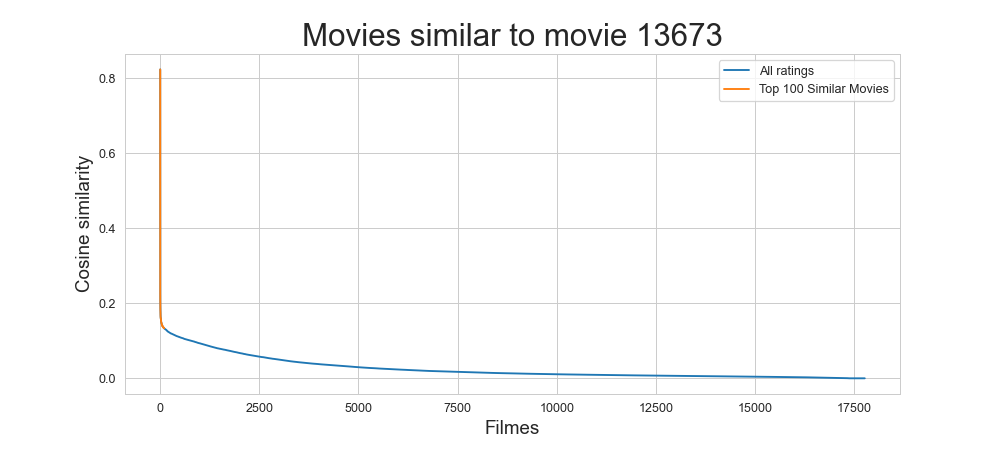

In [67]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
plt.plot(similarities[sim_indices], label = 'All ratings')
plt.plot(similarities[sim_indices[:100]], label = 'Top 100 Similar Movies')
plt.title("Movies similar to movie {}".format(movie_id), fontsize = 25)
plt.xlabel("Filmes", fontsize = 15)
plt.ylabel("Cosine similarity", fontsize = 15)
plt.legend()
plt.show()

In [68]:
# Here the top 10 movies most similar to the movie with the id chosen previously
movie_titles.loc[sim_indices[:10]]

,Release_Year,Title
Movie_Id,,
14571,1999.0,Toy Story 2
5250,1986.0,The Money Pit
2340,1990.0,Joe Versus the Volcano
6661,1996.0,That Thing You Do!
11199,1989.0,The 'Burbs
10428,1984.0,Splash: 20th Anniversary Edition
4207,1980.0,The Blues Brothers: Extended Cut
2290,1992.0,Aladdin: Platinum Edition
11089,2001.0,Monsters


## Here we completed our project, as we already have a recommendation system.